In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [135]:
def market_update( S_m , p ,delta ):
    U = np.random.rand()
    if U < p :
        S_m_new = S_m * delta
    else:
        S_m_new = S_m * delta**-1
    return S_m_new
def pool_update( S_p , S_m_new , gamma ):
    if S_m_new > gamma**-1*S_p :
        S_p_new =  gamma*S_m_new 
    elif S_m_new < gamma*S_p :
        S_p_new =  gamma**-1*S_m_new
    else:
        S_p_new = S_p
    return S_p_new

In [133]:
def pool_process( T , p , delta , gamma ):
    S_p = np.zeros(T+1)
    S_m = np.zeros(T+1)
    S_p[0]=1
    S_m[0]=1
    for i in range(T):
        S_m[i+1] = market_update( S_m[i] , p ,delta )
        S_p[i+1] = pool_update( S_p[i] , S_m[i+1] , gamma )
    return S_p , S_m

In [171]:
delta =1.0001
gamma = np.exp(-5*delta)
S_p , S_m = pool_process( 1000 , 0.6 , delta , gamma )

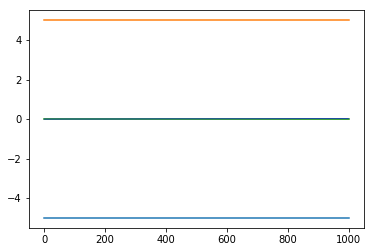

In [172]:
plt.figure()
T=np.arange(1001)
plt.plot(T, np.log(S_p) ,'g' )
plt.plot(T, np.log(gamma*S_p) )
plt.plot(T, np.log(S_p*(gamma**-1)))
plt.plot(T, np.log(S_m) , 'b',linewidth=0.5)
plt.show()

In [118]:
np.log(S_m)

array([  0.,  -1.,   0., ..., 202., 201., 202.])

In [119]:
np.log(S_p)

array([  0.        ,  -0.64332506,  -0.35667494, ..., 201.64332506,
       201.35667494, 201.64332506])